In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [2]:
import pandas as pd
import re
from unidecode import unidecode
def limpiar_convenio(texto):
    # Eliminar tildes
    texto_sin_tildes = unidecode(texto)
    # Convertir a minúsculas
    texto_limpio = texto_sin_tildes.lower()
    # Eliminar espacios en blanco adicionales
    texto_limpio = re.sub(r'\s+', ' ', texto_limpio)
    # Eliminar espacios al inicio y final del texto
    texto_limpio = texto_limpio.strip()
    # Eliminar caracteres especiales y números
    texto_limpio = re.sub(r'[^a-zA-Z\s]', '', texto_limpio)
    # Eliminar comillas
    texto_limpio = re.sub(r"\'", "", texto_limpio)
    # Eliminar links
    texto_limpio = re.sub(r'http\S+|www\S+|https\S+', '', texto_limpio)
    return texto_limpio

# Cargar el DataFrame desde el archivo CSV
df = pd.read_csv('dataset_convenios.csv')
# Aplicar la función limpiar_convenio a la columna "Convenios"
df['Convenio'] = df['Convenio'].apply(limpiar_convenio)


In [3]:
df.head(5)

,Convenio,Factibilidad,Etiqueta
0,unidad de organizacion ano del didlogo y la re...,0.007704,Factible
1,we s cortn f by michell convenio marco de co...,0.007391,Factible
2,ron programa nacional peru ministerio c de...,0.007171,Factible
3,convenio especifico entre la gerencia de red a...,0.005120,No Factible
4,were convenio marco de cooperacion interinstit...,0.006510,Factible


In [4]:
temp_cols=df.columns.tolist()
new_cols=temp_cols[1:] + temp_cols[0:1]
df=df[new_cols]
df.head(5)

,Factibilidad,Etiqueta,Convenio
0,0.007704,Factible,unidad de organizacion ano del didlogo y la re...
1,0.007391,Factible,we s cortn f by michell convenio marco de co...
2,0.007171,Factible,ron programa nacional peru ministerio c de...
3,0.005120,No Factible,convenio especifico entre la gerencia de red a...
4,0.006510,Factible,were convenio marco de cooperacion interinstit...


In [5]:
df.groupby('Etiqueta').describe()

Factibilidad                                                  \
                   count     mean       std      min       25%       50%   
Etiqueta                                                                   
Factible           285.0  0.00940  0.002953  0.00604  0.007391  0.008621   
No Factible         63.0  0.00499  0.000686  0.00225  0.004556  0.005120   

                                 
                  75%       max  
Etiqueta                         
Factible     0.010846  0.028070  
No Factible  0.005490  0.006004

In [6]:
df = df.drop(columns=['Factibilidad'])

In [7]:
df['Etiqueta'].value_counts()

Factible       285
No Factible     63
Name: Etiqueta, dtype: int64

In [8]:
df_nofacti = df[df['Etiqueta']=='No Factible']
df_nofacti.shape

(63, 2)

In [9]:
df_facti = df[df['Etiqueta']=='Factible']
df_facti.shape

(285, 2)

In [10]:
df_facti_downsampled = df_facti.sample(df_nofacti.shape[0])
df_facti_downsampled.shape

(63, 2)

In [11]:
df_balanced = pd.concat([df_facti_downsampled, df_nofacti])
df_balanced.shape 

(126, 2)

In [12]:
df_balanced['Etiqueta'].value_counts()

Factible       63
No Factible    63
Name: Etiqueta, dtype: int64

In [13]:
df_balanced['No Factible']=df_balanced['Etiqueta'].apply(lambda x: 1 if x=='No Factible' else 0)
df_balanced.sample(5)

,Etiqueta,Convenio,No Factible
37,Factible,universidad nacional del altiplano rectorado c...,0
290,No Factible,firmado digitalmente pe evedo huertas angela m...,1
214,No Factible,universidad nacional del altiplano rectorado c...,1
107,No Factible,universidad nacional del altiplano rectorado o...,1
55,No Factible,of ae vilvensy convenio especifico entre la ...,1


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Convenio'],df_balanced['No Factible'], stratify=df_balanced['No Factible'])

In [15]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [16]:
# Capas bert
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Capa de las redes neuronales
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [18]:
len(X_train)

94

In [19]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [20]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
3/3 [==============================] - 19s 4s/step - loss: 0.7030 - accuracy: 0.4574 - precision: 0.4643 - recall: 0.5532
Epoch 2/10
3/3 [==============================] - 12s 4s/step - loss: 0.6827 - accuracy: 0.5638 - precision: 0.5536 - recall: 0.6596
Epoch 3/10
3/3 [==============================] - 12s 4s/step - loss: 0.6710 - accuracy: 0.6277 - precision: 0.6875 - recall: 0.4681
Epoch 4/10
3/3 [==============================] - 11s 4s/step - loss: 0.6982 - accuracy: 0.5106 - precision: 0.5238 - recall: 0.2340
Epoch 5/10
3/3 [==============================] - 12s 4s/step - loss: 0.6959 - accuracy: 0.4894 - precision: 0.4865 - recall: 0.3830
Epoch 6/10
3/3 [==============================] - 12s 4s/step - loss: 0.6965 - accuracy: 0.5319 - precision: 0.5238 - recall: 0.7021
Epoch 7/10
3/3 [==============================] - 12s 4s/step - loss: 0.6928 - accuracy: 0.5213 - precision: 0.5161 - recall: 0.6809
Epoch 8/10
3/3 [==============================] - 11s 4s/step - loss:

In [21]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 5s 5s/step - loss: 0.6574 - accuracy: 0.7188 - precision: 0.6842 - recall: 0.8125


[0.6573752164840698, 0.71875, 0.6842105388641357, 0.8125]

In [22]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

1/1 [==============================] - 5s 5s/step


In [23]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1])

In [24]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[10,  6],
       [ 3, 13]], dtype=int64)

Text(50.722222222222214, 0.5, 'Verdad')

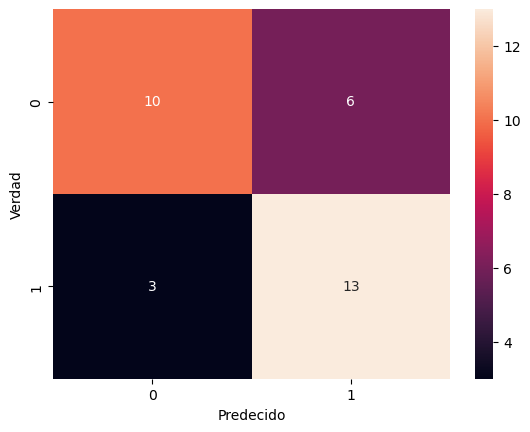

In [28]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predecido')
plt.ylabel('Verdad')


In [26]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.77      0.62      0.69        16
           1       0.68      0.81      0.74        16

    accuracy                           0.72        32
   macro avg       0.73      0.72      0.72        32
weighted avg       0.73      0.72      0.72        32



In [27]:
predictions = []  # Lista para almacenar las predicciones

for i in range(1, 11):
    filename = f'convenio{i:02d}.txt'
    with open(filename, 'r', encoding='utf-8') as file:
        text = file.read()
        prediction = model.predict([text])
        predictions.append(prediction)

# Imprimir las predicciones
for i, prediction in enumerate(predictions):
    print(f'Predicción para convenio{i+1:02d}: {prediction}')

1/1 [==============================] - 0s 180ms/step
Predicción para convenio01: [[0.40745863]]
Predicción para convenio02: [[0.49583554]]
Predicción para convenio03: [[0.5526722]]
Predicción para convenio04: [[0.57172054]]
Predicción para convenio05: [[0.45303944]]
Predicción para convenio06: [[0.398006]]
Predicción para convenio07: [[0.5616374]]
Predicción para convenio08: [[0.42374262]]
Predicción para convenio09: [[0.5474162]]
Predicción para convenio10: [[0.5239448]]
